In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
from torchvision import transforms
import torchvision
from tqdm import tqdm
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import warnings
warnings.simplefilter('ignore')
print("CUDA環境が壊れていないことを祈りながら確認-> ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

CUDA環境が壊れていないことを祈りながら確認->  False


In [23]:
transform = transforms.Compose([transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [24]:
class GNet(nn.Module):
    def __init__(self, z_size, num_filters, device = device) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_size, num_filters*8, 4,1,0,bias=False),
            nn.BatchNorm2d(num_filters*8),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(num_filters*8,num_filters*4,3,2,1,bias=False),
            nn.BatchNorm2d(num_filters*4),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(num_filters*4,num_filters*2,4,2,1,bias=False),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(num_filters*2,num_filters,4,2,1,bias=False),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(num_filters,3,5,1,0,bias=False),
            nn.Tanh()
        ).to(device)
    def forward(self,fake_data):
        """
        create_noise関数は(batch_size, z_size)のため、(batch_size, z_size, 1, 1)に入力を変更してから計算を行う
        """
        batch_size = fake_data.size(0)
        z_size = fake_data.size(1)
        fake_data = fake_data.view(batch_size,z_size,1,1)
        fake_img = self.model(fake_data)
        return fake_img.squeeze(1)

In [25]:
class DNet(nn.Module):
    def __init__(self,num_filters, image_size, device = device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,num_filters,5,1,0,bias=False),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters,num_filters*2,4,2,1,bias=False),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters*2,num_filters*4,4,2,1,bias=False),
            nn.BatchNorm2d(num_filters*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters*4,num_filters*8,3,2,1,bias=False),
            nn.BatchNorm2d(num_filters*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters*8,1,4,1,0,bias=False),
            nn.Sigmoid(),
        ).to(device)
        self.image_size = image_size
    def forward(self, data):
        data = data.view(-1,3,*self.image_size)
        out = self.model(data)
        return out.view(-1,1)

In [26]:
from GANutils.trainutils import create_input
epochs = 50
z_size = 64
D_losses = []
G_losses = []
num_filters = 32
image_size = (32,32)
gnet = GNet(z_size,num_filters).to(device)
dnet = DNet(num_filters,image_size).to(device)
optimizerG = optim.Adam(gnet.parameters(),lr = 2e-4)
optimizerD = optim.Adam(dnet.parameters(),lr = 2e-4)

In [27]:
batch_size = 64
z_size = 64
gnet = GNet(z_size,1)
z = create_input(batch_size,z_size).to(device)
gnet(z).shape

torch.Size([64, 3, 32, 32])

In [28]:
from GANutils.trainutils import trainGAN
import matplotlib.pyplot as plt
cifar_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
for epoch in tqdm(range(epochs)):
    all_D_loss = 0
    all_G_loss = 0
    for data in cifar_dl:
        data = data[0] / 255.
        data = data.to(device)
        criterion = nn.BCELoss()
        optimizerD.zero_grad()
        batch_size = data.size(0)
        real_label = torch.ones(batch_size,1).to(device)
        real_proba = dnet(data) #データの形状が合わない時はforward内部で入力ように整形変更することを想定して制作。
        D_loss_real = criterion(real_proba, real_label)
        input_z = create_input(batch_size,z_size).to(device)
        fake_data = gnet(input_z).to(device)
        fake_proba = dnet(fake_data).to(device)
        fake_label = torch.zeros(batch_size,1).to(device)
        D_loss_fake = criterion(fake_proba,fake_label)
        D_loss = D_loss_fake + D_loss_real
        D_loss.backward()
        optimizerD.step()
        #D_lossのところでGenerate Modelのパラメータの勾配も計算されている為、Generate Modelに関する勾配はここで初期化を行う
        optimizerG.zero_grad()
        input_z = create_input(batch_size,z_size).to(device)
        fake_data = gnet(input_z)
        fake_proba = dnet(fake_data)
        real_label = torch.ones(batch_size,1).to(device) #ラベルが1になるように(騙すように)訓練するので、ラベルは1を予測するように作る
        G_loss = criterion(fake_proba,real_label)
        G_loss.backward()
        optimizerG.step()
        D_loss, G_loss = D_loss.detach().item(), G_loss.detach().item()
        all_D_loss += D_loss
        all_G_loss += G_loss
    D_losses.append(all_D_loss/len(cifar_dl))
    G_losses.append(all_G_loss/len(cifar_dl))
    if epoch % 10 == 0:
        print(f"Discriminator Loss: {D_loss},Generater Loss: {G_loss}")
print(f"Discriminator Loss: {D_loss},Generater Loss: {G_loss}")

  2%|▏         | 1/50 [01:38<1:20:25, 98.49s/it]

Discriminator Loss: 3.2739048037910834e-05,Generater Loss: 11.97514533996582


 22%|██▏       | 11/50 [23:06<1:22:59, 127.67s/it]

Discriminator Loss: 4.0978196835794733e-08,Generater Loss: 17.44725227355957


 32%|███▏      | 16/50 [3:02:48<6:28:27, 685.50s/it]  


KeyboardInterrupt: 

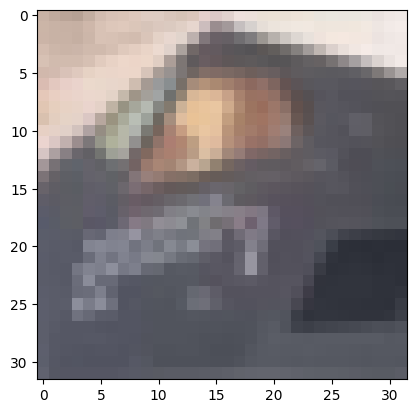

In [32]:
import matplotlib.pyplot as plt
topil = transforms.ToPILImage()
plt.imshow(topil(data[0]*255))

In [33]:
z = create_input(batch_size,z_size).to(device)
fake_img = gnet(z)

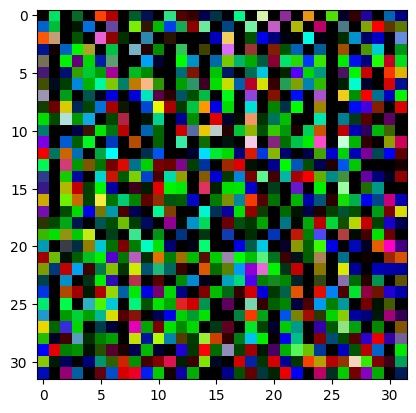

In [36]:
import matplotlib.pyplot as plt
plt.imshow(topil(fake_img[0].clip(0,1)*255))